In [1]:
!curl https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip -o sed.zip
!unzip sed.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 69 1079M   69  745M    0     0  19.8M      0  0:00:54  0:00:37  0:00:17 20.8MA
100 1079M  100 1079M    0     0  20.1M      0  0:00:53  0:00:53 --:--:-- 20.9M
Archive:  sed.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
 

In [2]:
import os
print(os.listdir("dogImages"))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import datasets, transforms, models
import torch.nn.functional as F

# Any results you write to the current directory are saved as output.
from torchsummary import summary
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage import io, transform
import torch.optim as optim

import torch.utils.data as data_utils
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


['train', 'valid', 'test']
CUDA is available!  Training on GPU ...


In [3]:
data_transforms = {
    'train': transforms.Compose([
#        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),    
}

data_dir = "dogImages" 
batch_size = 64

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}
    
loaders_data = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size,
                                              shuffle = True)
                  for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
n_classes = len(class_names)
  

# print statistics about the dataset
print(f"No. of Training Records: {dataset_sizes['train']}")
print(f"No. of Validation Records: {dataset_sizes['valid']}")
print(f"No. of Testing Records: {dataset_sizes['test']}")      
print(f"No. of Classes: {n_classes}")
 

No. of Training Records: 6680
No. of Validation Records: 835
No. of Testing Records: 836
No. of Classes: 133


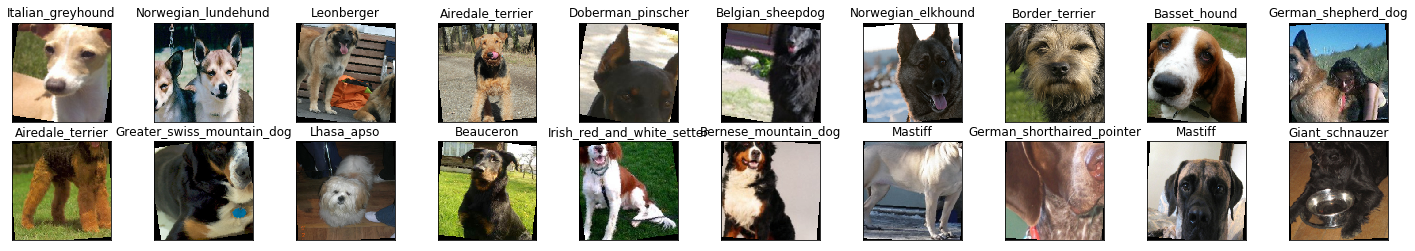

In [4]:

def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)    
    plt.imshow(inp)
    
# Get a batch of training data
images, classes = next(iter(loaders_data['train']))
      
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[classes[idx]].split(".")[1])

In [5]:
resnet = models.densenet161(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.classifier.in_features
resnet.classifier = nn.Linear(num_ftrs, n_classes)


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:02<00:00, 46.3MB/s]


In [0]:
optimizer = optim.Adam(resnet.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [0]:
model = resnet.cuda()

In [8]:
torch.cuda.empty_cache()
n_epochs = 20   
valid_loss_min = np.Inf
for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders_data['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders_data['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(),"dogs.pth")
            valid_loss_min = valid_loss
          


Epoch: 1 	Training Loss: 2.224311 	Validation Loss: 0.761606
Validation loss decreased (inf --> 0.761606).  Saving model ...
Epoch: 2 	Training Loss: 0.934952 	Validation Loss: 0.503767
Validation loss decreased (0.761606 --> 0.503767).  Saving model ...
Epoch: 3 	Training Loss: 0.842219 	Validation Loss: 0.427978
Validation loss decreased (0.503767 --> 0.427978).  Saving model ...
Epoch: 4 	Training Loss: 0.760038 	Validation Loss: 0.429464
Epoch: 5 	Training Loss: 0.717486 	Validation Loss: 0.416339
Validation loss decreased (0.427978 --> 0.416339).  Saving model ...
Epoch: 6 	Training Loss: 0.695444 	Validation Loss: 0.402588
Validation loss decreased (0.416339 --> 0.402588).  Saving model ...
Epoch: 7 	Training Loss: 0.705680 	Validation Loss: 0.507517
Epoch: 8 	Training Loss: 0.637489 	Validation Loss: 0.432811
Epoch: 9 	Training Loss: 0.660972 	Validation Loss: 0.399790
Validation loss decreased (0.402588 --> 0.399790).  Saving model ...
Epoch: 10 	Training Loss: 0.599487 	Valida

KeyboardInterrupt: ignored

In [0]:
model.load_state_dict(torch.load('dogs.pth'))

In [10]:
 # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders_data['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

Test Loss: 0.440656


Test Accuracy: 85% (718/836)
